In [3]:
import sys
import os
from mpi4py import MPI
import h5py
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format = 'png'

import floatpy.readers.padeops_reader as por
import floatpy.readers.parallel_reader as pdr
import floatpy.utilities.reduction as red
import floatpy.derivatives.compact.compact_derivative as cd
import scripts.statistics as stats

dtheta_inc = { #Brown & Roshko Fig. 15
    0: 0.1*0.24026898560883186,
    1: 0.1*0.180376365676346,
    7: 0.1*0.1338770483624053
}

# PadeOps
dtheta = {
    0.2: 0.8313409423823516,
    0.4: 0.6704432477570811,
    0.8: 0.456550549109,
    1.2: 0.3444444444,
    1.6: 0.291629202186,
    2.0: 0.251843521922}

# Computed as (dtheta/dtheta_inc)/tID
dtheta_ovf0 = {
    0.2: 0.0563699184027,
    0.4: 0.0903756196906,
    0.8: 0.122673068418,
    1.2: 0.17222331184,
    1.6: 0.201820655095,
    2.0: 0.171049764446,
}
DTPHYS = 0.075
FSMACH = 0.4
for Mc, value in dtheta_ovf0.iteritems():
    tscale = DTPHYS/FSMACH
    du = 2*Mc
    dtheta_ovf0[Mc] /= tscale*du
    
# Computed as integrated reynolds stress 
dtheta_ovf = {
    0.2: 0.7,
    0.4: 0.68,
    0.8: 0.42,
    1.2: 0.40,
    1.6: 0.27,
    2.0: 0.25}

Text(0,0.5,'$\\dot{\\delta}/\\dot{\\delta_{inc}}$')

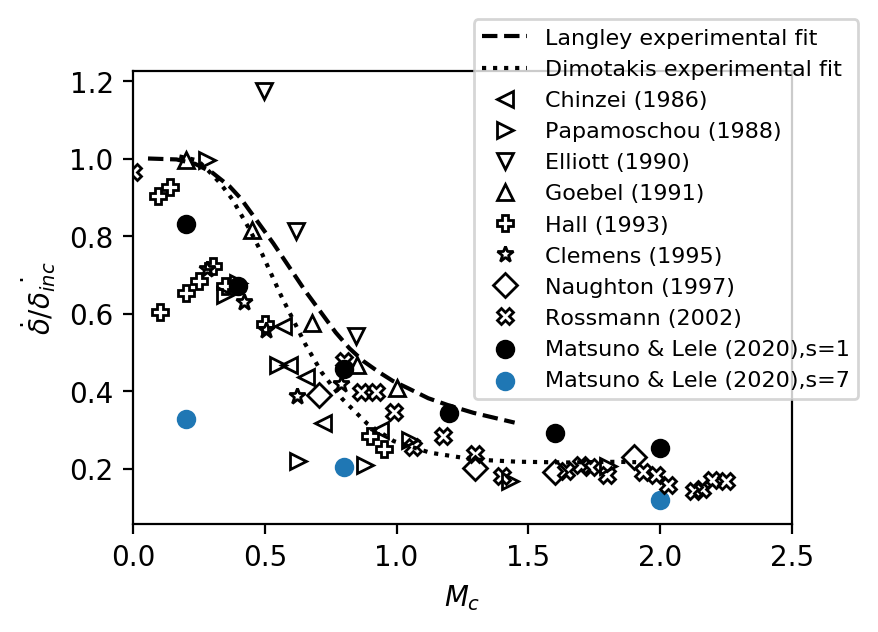

In [4]:
# Literature comparison
def read_data(fname):
    dat = np.fromfile('/home/kmatsuno/FloATPy/post/lit/'+fname,dtype=float, count=-1, sep=' ')
    dat = np.array(dat)
    n = np.size(dat)/2
    dat = np.reshape(dat,[n,2])
    return dat[:,0],dat[:,1]

def get_files(path):
    for file in os.listdir(path):
        if os.path.isfile(os.path.join(path, file)):
            yield file
markers = {'Chinzei':'<','Papamoschou':'>','Elliott':'v','Goebel':'^','Hall':'P',
           'Clemens':'*','Naughton':'D','Rossmann':'X'}

def plot_lit():
    # Experimental fit
    Mc,growth=read_data('fits/Langley')
    plt.plot(Mc,growth,'k--',alpha=1,label='Langley experimental fit')
    Mc,growth=read_data('fits/Dimotakis')
    plt.plot(Mc,growth,'k:',alpha=1,label='Dimotakis experimental fit')

    # data files
    files = [f for f in get_files('/home/kmatsuno/FloATPy/post/lit/')]
    years = [f[-4::] for f in files]
    file_dict = {}
    for i in range(len(files)):
        auth,year = files[i].split('_')
        file_dict[year] = auth

    for year in sorted(years):
        auth = file_dict[year]
        if auth=='Pantano': pass
        else:
            Mc,growth = read_data(auth+'_'+year)
            plt.plot(Mc,growth,'k',marker=markers[auth],label=auth + ' ('+year+')',
                     linestyle='none',fillstyle='none')
        
# PadeOps data:
plt.figure(figsize=(4.25,3.0),dpi=200)
plot_lit()
plt.scatter(dtheta.keys(),dtheta.values(),marker='o',color='k',label='Matsuno & Lele (2020),s=1')
plt.scatter(dtheta_rr7.keys(),dtheta_rr7.values(),marker='o',color='C0',label='Matsuno & Lele (2020),s=7')
plt.legend(bbox_to_anchor=(0.5, 0.25),fontsize=8)
plt.xlabel('$M_c$')
plt.xlim([0,2.5])
plt.ylabel('$\dot{\delta}/\dot{\delta_{inc}}$')
# plt.savefig('/home/kmatsuno/ShearLayer_img/growth_lit.png',dpi=200, bbox_inches='tight')


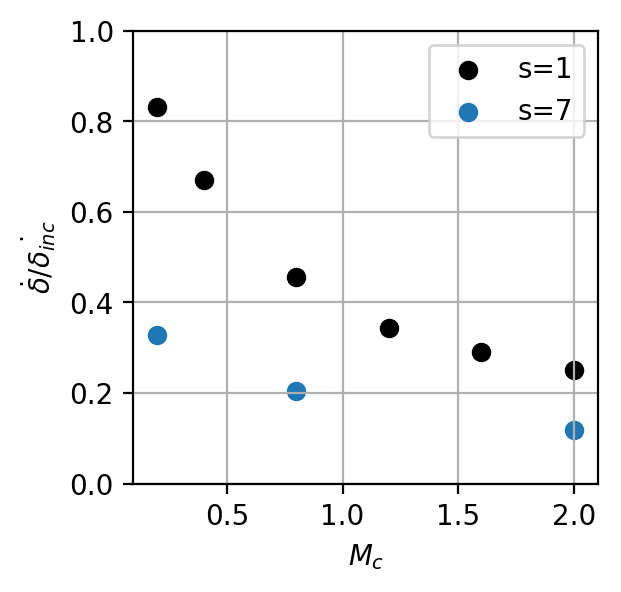

In [4]:
# Density ratio comparison

dtheta_rr7 = {
    0.2: 0.328048356838,
    0.8: 0.204785171464,
    2.0: 0.118529228172
}
# dtheta_rr_7 = {
#     0.2: 0.41845482067134454,
#     0.8: 0.2876450364869774,
#     2.0: 0.1519875160790215
# }

def merge_dicts(old1,old2):
    new = {}
    for i in range(3):
        key = old1.keys()[i]
        v1 = old1.values()[i]
        v2 = old2.values()[i]
        std = np.std([v1,v2]) 
        new[key] = [(v1+v2)/2.,std]
    return new

rr = dtheta_rr7#merge_dicts(dtheta_rr7,dtheta_rr_7)

plt.figure(figsize=(3,3),dpi=200)
# Pantano
# plt.plot(0.7,0.36,'^',color='C3',label='Pantano (2001)')
plt.scatter(dtheta.keys(),dtheta.values(),marker='o',color='k',label='s=1')
plt.scatter(rr.keys(),rr.values(),marker='o',label='s=7')

plt.ylim([0,1])
plt.grid(True)
plt.xlabel('$M_c$')
plt.ylabel('$\dot{\delta}/\dot{\delta_{inc}}$')
plt.legend()
plt.savefig('/home/kmatsuno/ShearLayer_img/growth_rr.png',dpi=200, bbox_inches='tight')


(0.25, 0.5)

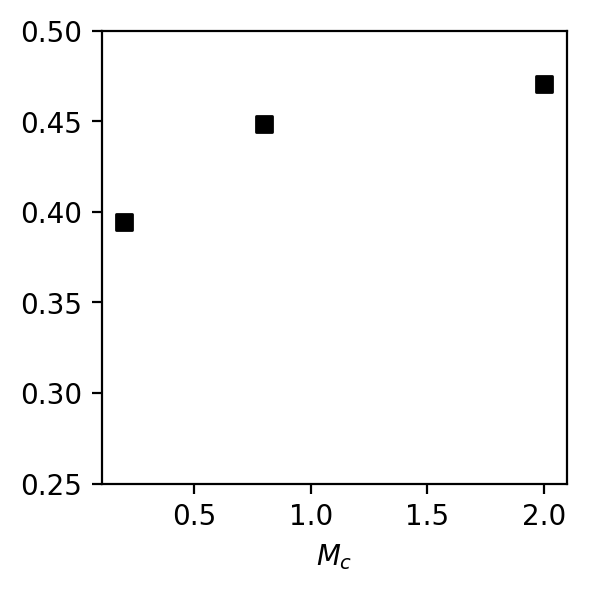

In [7]:

ratio = {}
for key in rr.keys():
    ratio[key] = rr[key]/dtheta[key]

plt.figure(figsize=(3,3),dpi=200)
dat = ratio
plt.scatter(dat.keys(),dat.values(),marker='s',color='k')

plt.xlabel('$M_c$')
# plt.grid(True)
plt.ylim([0.25,0.5])
# plt.savefig('/home/kmatsuno/ShearLayer_img/growth_rr.png',dpi=200, bbox_inches='tight')


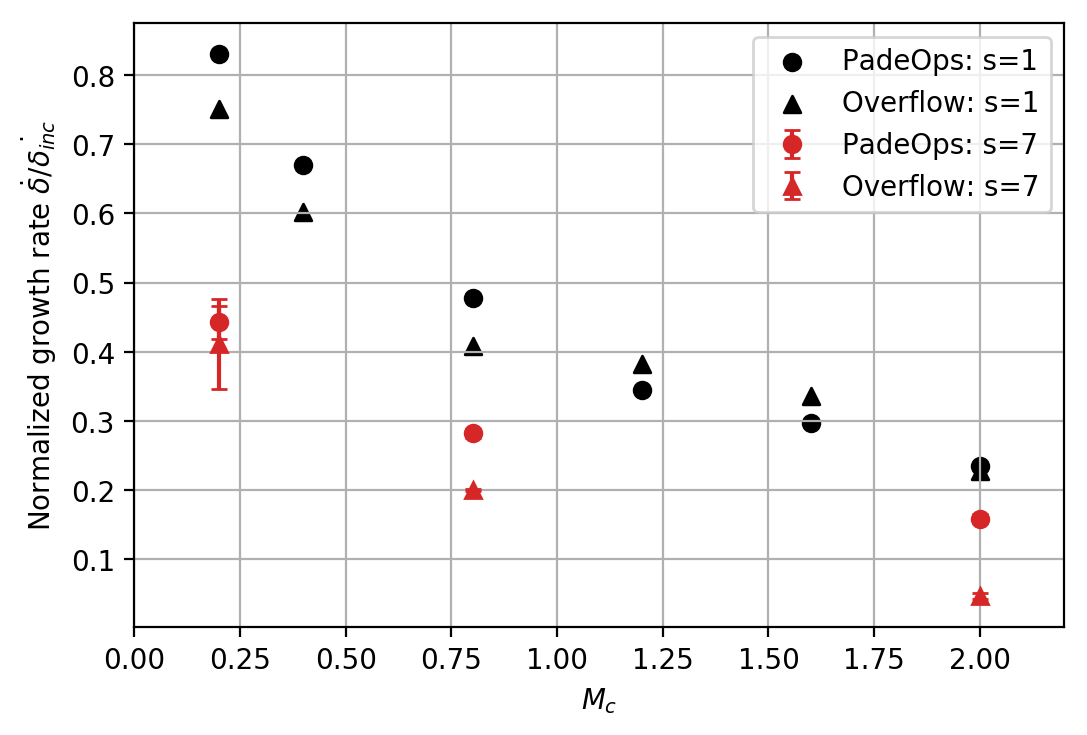

In [5]:
# COMPARE OVF 

dtheta_ovf = {
    0.2: 0.0563699184027,
    0.4: 0.0903756196906,
    0.8: 0.122673068418,
    1.2: 0.17222331184,
    1.6: 0.201820655095,
    2.0: 0.171049764446,
}
DTPHYS = 0.075
FSMACH = 0.4
for Mc, value in dtheta_ovf.iteritems():
    tscale = DTPHYS/FSMACH
    du = 2*Mc
    dtheta_ovf[Mc] /= tscale*du

dtheta_rr7_ovf = {
    0.2: 0.05186,
    0.8: 0.03024,
    2.0: 0.006317
}
DTPHYS = 0.075
for Mc, value in dtheta_rr7_ovf.iteritems():
    FSMACH = Mc
    tscale = DTPHYS/FSMACH
    du = 2*Mc
    dtheta_rr7_ovf[Mc] /= tscale*du
    
dtheta_rr_7_ovf = {
    0.2: 0.07154,
    0.8: 0.02977,
    2.0: 0.007639
}
for Mc, value in dtheta_rr_7_ovf.iteritems():
    FSMACH = Mc
    tscale = DTPHYS/FSMACH
    du = 2*Mc
    dtheta_rr_7_ovf[Mc] /= tscale*du

rr_ovf = merge_dicts(dtheta_rr7_ovf,dtheta_rr_7_ovf)

    
plt.figure(figsize=(6,4),dpi=200)
plt.scatter(dtheta.keys(),dtheta.values(),marker='o',color='k',label='PadeOps: s=1')
# plt.scatter(dtheta_rr_7.keys(),dtheta_rr_7.values(),marker='o',label='PadeOps: s=1/7')
# plt.scatter(dtheta_rr7.keys(),dtheta_rr7.values(),marker='o',label='PadeOps: s=7')
plt.errorbar(rr.keys(),[x[0] for x in rr.values()], yerr=[x[1] for x in rr.values()],fmt='o',color='C3',label='PadeOps: s=7',capsize=3)


plt.scatter(dtheta_ovf.keys(),dtheta_ovf.values(), marker='^',color='k',label='Overflow: s=1')
# plt.scatter(dtheta_rr_7_ovf.keys(),dtheta_rr_7_ovf.values(), marker='*',color='C0',label='Overflow: s=1/7')
# plt.scatter(dtheta_rr7_ovf.keys(),dtheta_rr7_ovf.values(), marker='*',color='C1',label='Overflow: s=7')
plt.errorbar(rr_ovf.keys(),[x[0] for x in rr_ovf.values()], yerr=[x[1] for x in rr_ovf.values()],fmt='^',color='C3',label='Overflow: s=7',capsize=3)

plt.xlim([0,2.2])
plt.xlabel('$M_c$')
plt.ylabel('Normalized growth rate $\dot{\delta}/\dot{\delta_{inc}}$')
plt.legend()
plt.grid(True)

plt.savefig('/home/kmatsuno/Ovf_compare/growth_rr.png',dpi=200, bbox_inches='tight')